# Deep Image Prior (DIP) for PAM - Batch Mode Only
## Tri Vu - Updated 051620

### Import libs and utils

In [1]:
import keras
from keras import backend as K
import tensorflow as tf
from define_model import *
from build_unet import *
from utils import *
from keras.optimizers import Adam
import os
from os.path import isfile, join
from numba import cuda

Using TensorFlow backend.


In [2]:
""" Choose which gpu to run the training """
gpu = 1  # 0 for first gpu, 1 for 2nd gpu
if gpu == 0:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
elif gpu == 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Step 1: Mode Selection

In [3]:
BATCH_MODE = False  # Run DIP on a set of data for evaluation
WHOLEIMG_MODE = True   # Run DIP on the whole image with 300x300 subimgs

SAVE_MODEL = False  # Save trained model and input noise
SAVE_LOSS = False
SAVE_OUTPUT = False  # Save auxillary info (training time and noise reg) output image, 
                    # with corrected image in the 2nd channel

### Step 2: Params Input and Pre-processing

In [4]:
if BATCH_MODE:
    imgpath = './Data/5_1/'
    batch_range = 50
    list_dir = os.listdir(imgpath)
    list_file = [f for f in list_dir if isfile(join(imgpath, f))]
    prefix, suffix = list_file[0].split('.')
    print(suffix)

In [5]:
if WHOLEIMG_MODE:
    IMG_SIZE = 260
    imgpath = './Data/'
    imgname = 'leaf_xiaoyi_6'
    imgsuffix = 'png'
    im_all = cv2.imread(imgpath + imgname + '.' + imgsuffix)

    if im_all.shape[0] % IMG_SIZE != 0:
        num_x = im_all.shape[0]//IMG_SIZE
        dim_x = num_x*IMG_SIZE
    else:
        num_x = im_all.shape[0]//IMG_SIZE
        dim_x = im_all.shape[0]
    if im_all.shape[1] % IMG_SIZE != 0:
        num_y = im_all.shape[1]//IMG_SIZE
        dim_y = num_y*IMG_SIZE
    else:
        num_y = im_all.shape[1]//IMG_SIZE
        dim_y = im_all.shape[1]

    im_all = im_all[:dim_x, :dim_y, :]
    im_out = np.zeros((im_all.shape[0], im_all.shape[1]))
    im_down_out = np.copy(im_out)
    im_all = np.pad(im_all, ((20, 20), (20, 20), (0,0)), 'constant')  # zero pad 20x20 along axis 0 and 1

    lin_x = np.arange(150, im_all.shape[1], 260)
    lin_y = np.arange(150, im_all.shape[0], 260)
    total_count = len(lin_x)*len(lin_y)
    print(total_count)
    
    count = 1
    for i in lin_x:
        for j in lin_y:
            print(count)
            im_temp = im_all[j-150:j+150, i-150:i+150, :]
            im, im_gt, im_masked, im_mask, im_down, factor = readImg(im_temp)
            [sr_image, l, model, 
             totalTrainingTimeHr, 
             input_noise] = train_dp(im_masked, im_gt, im_mask, iter=5000, 
                     noise_reg=0.07, show_output=False)
            tmp = np.squeeze(sr_image)
            im_out[j-150:j+110, i-150:i+110] = tmp[20:280, 20:280]
            im_down_out[j-150:j+110, i-150:i+110] = im_down[20:280, 20:280]
            count += 1

#     plt.imshow(im_out[100:200, 100:200, 1])
#     plt.show()
#     plt.imshow(im_all[100:200, 100:200, 1])
#     plt.show()
    # im, im_gt, im_masked, im_mask, im_down, factor = readImg(im)
    # constructPlot(im, 
    #               ['', 'Mask', 'Sparsely-sampled', 'Fully-sampled'], 
    #               fsize=(10,10))

10
1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
2
3
4
5
6
7
8
9
10


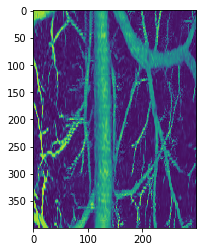

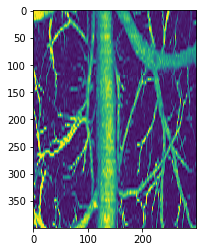

In [6]:
plt.imshow(im_out[400:800, 200:500])
plt.show()
plt.imshow(im_down_out[400:800, 200:500])
plt.show()

(1300, 520)
(1300, 520)


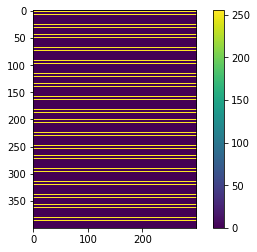

In [23]:
im_out_ts = norm_uint8(im_out)
print(im_out_ts.shape)
im_mask_ts = norm_uint8(im_all[20:-20, 20:-20, 0]*255)
print(im_mask_ts.shape)
im_gt_ts = np.zeros(im_out_ts.shape)
im_ts = np.dstack((im_mask_ts, im_out_ts, im_gt_ts))
plt.imshow(im_mask_ts[400:800, 200:500])
plt.colorbar()
plt.show()

In [24]:
cv2.imwrite(imgpath + imgname + '_dip_out.png', im_ts)

True

In [7]:
# For examining noise regularization
if BATCH_MODE:
    count = 1
    for f in list_file:        
        print('Current count: ' + str(count))
        print(f)
        
        imgname, imgsuffix = f.split('.')
        if imgsuffix != 'png':
            continue
        
        try:
            im = cv2.imread(imgpath + imgname + '.' + imgsuffix)
            im, im_gt, im_masked, im_mask, im_down, factor = readImg(im)
            [sr_image, l, model, totalTrainingTimeHr, input_noise] = train_dp(im_masked, im_gt, im_mask, iter=5000,
                                                                                 noise_reg=0.07)

            sr_image = np.squeeze(sr_image)
            im_out = np.dstack((im_mask, sr_image, im_gt))
        except:
            continue
                
        
        if SAVE_MODEL:
            model.save(imgpath + '/output/' + imgname + '.h5')
            inputNoise = np.squeeze(input_noise)
            inputNoise = inputNoise.reshape((inputNoise.shape[0], 
                                             inputNoise.shape[1]*inputNoise.shape[2]))
            np.savetxt(imgpath + '/output/' + imgname + '_inputNoise.txt', 
                       np.asarray(np.squeeze(inputNoise)))
        if SAVE_OUTPUT:
            cv2.imwrite(imgpath + '/output/' + imgname + '_dip_out.png', im_out)
            np.savetxt(imgpath + '/output/' + imgname + '_Aux.txt', 
                       np.asarray([totalTrainingTimeHr]))
            
        if SAVE_LOSS:
            np.savetxt(imgpath + '/output/' + imgname + '_loss.txt', 
                       np.asarray(l))
#         ssim_rec = np.concatenate((ssim_rec, [[ii, cur_ssim]]), axis=0)
        
        if count < batch_range:
#             del model
            K.clear_session()
#             cuda.select_device(0)
#             cuda.close()
            print('Session cleared.')
        elif count == batch_range:
            break
            
        count += 1
    
print('Done')

Done


In [8]:
im.shape

(300, 300, 3)

In [9]:
totalTrainingTimeHr

15.259548048178354